In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
from scipy import stats
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from scipy import stats

from config import *
from vae_utility import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
original_dim = 3

latent_dim = 3
intermediate_dim = 50
kernel_max_norm = 500.
act_fun = 'relu'
weight_KL_loss = 0.6

Nf_lognorm = 3
Nf_PDgauss = 0

In [3]:
cols_ordered = ['met', 'mt', 'mbb', 'mct2',
        'mlb1', 'lep1Pt', 'nJet30', 'nBJet30_MV2c10', 'weight']

In [4]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    fraction = par3[:,3:4]
    x_clipped = K.clip(x[:,3:4], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,3:4], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,4:5]
    sigma = par2[:,4:5]
    fraction = par3[:,4:5]
    x_clipped = K.clip(x[:,4:5], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,4:5], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_6(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    norm_xp = K.tf.divide(x[:,5:6] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,5:6] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,6:7]
    sigma = par2[:,6:7]
    norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



In [5]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

class CustomIndividualLogNorLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w = ind_w[3])

class CustomIndividualLogNorLayer_5(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_5, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w = ind_w[4])

#         class CustomIndividualLogNorLayer_6(Layer):
#             def __init__(self, **kwargs):
#                 self.is_placeholder = True
#                 super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

#             def call(self, inputs):
#                 x, par1, par2, par3 = inputs
#                 return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

class CustomIndividualTruGauLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_6(x, par1, par2, w = ind_w[5])

class CustomIndividualTruGauLayer_7(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_7, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_7(x, par1, par2, w = ind_w[6])

In [6]:
from keras.models import load_model
custom_objects = {
    'original_dim': 3,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,
    'CustomIndividualLogNorLayer_4' : CustomIndividualLogNorLayer_4,
    'CustomIndividualLogNorLayer_5' : CustomIndividualLogNorLayer_5,
#     'CustomIndividualLogNorLayer_6' : CustomIndividualLogNorLayer_6,
    
    'CustomIndividualTruGauLayer_6' : CustomIndividualTruGauLayer_6,
    'CustomIndividualTruGauLayer_7' : CustomIndividualTruGauLayer_7,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [7]:
# cols_sel = [ 'met', 'mt', 'mct2','mlb1','lep1Pt', 'nJet30',
#         'nBJet30_MV2c10'
#             ]
cols_sel = [ 'met', 'mt', 'mct2'
            ]

In [8]:
weight_KL_loss = 0.6

path = 'model_results/model_dependent/bump_multiple_train/275_50/0_1_2_ft_3/w_5_10_10/vae_3.h5'
# path = 'model_results/model_dependent/bump_multiple_train/500_100/bump_feat_0_1_2_3_feat_0_300/bump_weights_1_1_1/vae_0.h5'
# path = 'model_results/model_dependent/bump_multiple_train/600_50/0_1_2_ft_3/w_5_10_10/vae_3.h5'

sig_inj = path.split('/')[3]
# latent_dim = path.split('/')[-1].split('feat_')[-1].split('_ld')[-1].split('.')[0].lstrip('_')

check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

you are loading a vae model vae_3.h5
{'met': 5, 'mt': 10, 'mct2': 10}


In [9]:
infer_component = False #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['met', 'mt', 'mct2']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    else:    
        selected_components = ['met', 'mt', 'mct2']
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]


Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-3]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('lognorm {} and pdgauss {}'.format(Nf_lognorm, Nf_PDgauss))

no zeros in the weights
no zeros in the weights, custom loss component definitions ['met', 'mt', 'mct2']
lognorm 3 and pdgauss 0


In [10]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_3.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [11]:
if path.split('/')[1] != 'model_dependent':
    
    model_dependent = False
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')
        sample = 'background_val.npy'

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    print('model independent test, val reweighting {}, {}'.format(split_test, split_val))

    
elif path.split('/')[1] == 'model_dependent':
    
    model_dependent = True
    
    name_sig = sig_inj

    back = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    
    sig_val = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    val_bkg_only = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        
        test_bkg_only = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_test_{}.npy'\
                  .format(name_sig, name_sig))
    
        sig_test = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test')

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    split_val_bkg_only = 1/(np.sum(val_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    print('model dependent on {}'.format(sig_inj))

model dependent on 275_50


In [12]:
signal_sys_d_name = [os.listdir(numpy_sig_syst_down)[os.listdir(numpy_sig_syst_down).index('275p0_50p0')]]
signal_sys_u_name = [os.listdir(numpy_sig_syst_up)[os.listdir(numpy_sig_syst_up).index('275p0_50p0')]]
signal_sys_d_name == signal_sys_u_name

True

In [13]:
len(val)

1014922

In [14]:
start_c = 0
end_c = 3

reg = 'all'
regs =        [ 'all',    'signal',   'reg_2',   'reg_3']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

temp = []
temp_name = []

signals_d_dict = {}
signal_names_d = []
nominal_signal_names = []

sig_df_mbb_d=[]

for sig_fold in signal_sys_d_name:
#     print(sig_fold)
    
    dir = numpy_sig_syst_down + '{}/'.format(sig_fold)
    signal_sys_d_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    
    for i, name in enumerate(signal_sys_d_name_branches):
        
        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
        sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

        sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
        sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
        sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
        sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
        sig_df_mbb= sig_df[ ['mbb'] + ['weight']]
        sig = (sig_df[cols_sel[start_c:end_c] + ['weight']]).values
        temp.append(sig)
        sig_df_mbb_d.append(sig_df_mbb)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)               
        
    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    sig_load = np.load(numpy_sig + nominal_sig_name)
    
    sig_df = pd.DataFrame(sig_load, columns=cols)
    sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
    sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]
    sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
    sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
    sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
    sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
    sig_df_mbb_nominal= sig_df[ ['mbb'] + ['weight']]
    sig = (sig_df[cols_sel[start_c:end_c] + ['weight']]).values
    
    temp.append(sig)

    signals_d_dict[nominal_name] = temp
    signal_names_d.append(temp_name)
    nominal_signal_names.append(temp_name[-1])
    sig_df_mbb_d.append(sig_df_mbb_nominal)

In [15]:
temp = []
temp_name = []
sig_df_mbb_u=[]
signals_u_dict = {}
signal_names_u = []
nominal_signal_names = []

for sig_fold in signal_sys_u_name:
#     print(sig_fold)
    
    dir =  numpy_sig_syst_up + '{}/'.format(sig_fold)
    signal_sys_u_name_branches = os.listdir(dir)
    temp = []
    temp_name= []
    
    for i, name in enumerate(signal_sys_u_name_branches):

        sig_load = np.load(dir + name)
        sig_df = pd.DataFrame(sig_load, columns=cols)
        sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
        sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

        sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
        sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
        sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
        sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
        sig_df_mbb= sig_df[ ['mbb'] + ['weight']]
        sig = (sig_df[cols_sel[start_c:end_c] + ['weight']]).values
        temp.append(sig)
        sig_df_mbb_u.append(sig_df_mbb)
        
        if 'p0' in name:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p0')[0:]).split('.')[0]
        else:
            sys_name =''.join(name.split('Wh_hbb_')[1].split('p5')[0:]).split('.')[0]
            
        temp_name.append(sys_name)               
        
    nominal_sig_name = 'Wh_hbb_'+sig_fold+'_0.npy'

    if 'p0' in nominal_sig_name:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p0')[0:2])
    else:
        nominal_name=''.join(nominal_sig_name.split('Wh_hbb_')[1].split('p5')[0:2])
            
    temp_name.append(nominal_name) 
    
    sig_load = np.load(numpy_sig + nominal_sig_name)
    sig_df = pd.DataFrame(sig_load, columns=cols)
    sig_df = sig_df[((sig_df['mbb']>=range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
    sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

    sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
    sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
    sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
    sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
    sig_df_mbb_nominal= sig_df[ ['mbb'] + ['weight']]
    sig = (sig_df[cols_sel[start_c:end_c] + ['weight']]).values
    temp.append(sig)
    sig_df_mbb_u.append(sig_df_mbb_nominal)

    signals_u_dict[nominal_name] = temp
    signal_names_u.append(temp_name)
    nominal_signal_names.append(temp_name[-1])

In [16]:
# cols_sel = ['met', 'mt', 'mct2', 'mlb1', 'lep1Pt', 'nJet30', 'nBJet30_MV2c10']
cols_sel = ['met', 'mt', 'mct2']

In [18]:
sample_name = 'test'

start_c = 0
end_c = 3

reg = 'all'
regs =        [ 'all',    'signal',   'reg_2',   'reg_3']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350]]

range_mbb = ranges_mbb[regs.index(reg)]

if sample_name == 'val':
    
    range_mct2 = [100,1000]
    
    val_factor = split_val

    val_df = pd.DataFrame(val, columns=cols)
    val_df = val_df[((val_df['mbb']>=range_mbb[0])&(val_df['mbb']<range_mbb[1]))]
    val_df = val_df[((val_df['mct2']>=range_mct2[0])&(val_df['mct2']<range_mct2[1]))]

    val_df = val_df[((val_df['mt']>=0)&(val_df['mt']<1000))]
    val_df = val_df[((val_df['met']>=0)&(val_df['met']<1000))]
    val_df = val_df[((val_df['mlb1']>=0)&(val_df['mlb1']<1000))]
    val_df = val_df[((val_df['lep1Pt']>=0)&(val_df['lep1Pt']<1000))]
    sample = (val_df[cols_sel[start_c:end_c] + ['weight']]).values

    out_bkg = vae.predict(sample[:,:-1], batch_size=2000)
    loss_bkg = np.column_stack((weight_KL_loss*out_bkg[0]+out_bkg[1], 
                                      out_bkg[1], out_bkg[0])).T
    
    if model_dependent:
        
        range_mct2 = [100,1000]

        val_factor = split_val
        val_df_b = pd.DataFrame(val_bkg_only, columns=cols)
        val_df_b = val_df_b[((val_df_b['mbb']>=range_mbb[0])&(val_df_b['mbb']<range_mbb[1]))]
        val_df_b = val_df_b[((val_df_b['mct2']>=range_mct2[0])&(val_df_b['mct2']<range_mct2[1]))]

        val_df_b = val_df_b[((val_df_b['mt']>=0)&(val_df_b['mt']<1000))]
        val_df_b = val_df_b[((val_df_b['met']>=0)&(val_df_b['met']<1000))]
        val_df_b = val_df_b[((val_df_b['mlb1']>=0)&(val_df_b['mlb1']<1000))]
        val_df_b = val_df_b[((val_df_b['lep1Pt']>=0)&(val_df_b['lep1Pt']<1000))]
        sample_b = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values

        out_bkg_only = vae.predict(sample_b[:,:-1], batch_size=2000)
        loss_bkg_only = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
                                      out_bkg_only[1], out_bkg_only[0])).T
    

if sample_name == 'test':
    
    range_mct2 = [100,1000]
    
    val_factor = split_test

    test_df = pd.DataFrame(test, columns=cols)
    test_df = test_df[((test_df['mbb']>=range_mbb[0])&(test_df['mbb']<range_mbb[1]))]
    test_df = test_df[((test_df['mct2']>=range_mct2[0])&(test_df['mct2']<range_mct2[1]))]

    test_df = test_df[((test_df['mt']>=0)&(test_df['mt']<1000))]
    test_df = test_df[((test_df['met']>=0)&(test_df['met']<1000))]
    test_df = test_df[((test_df['mlb1']>=0)&(test_df['mlb1']<1000))]
    test_df = test_df[((test_df['lep1Pt']>=0)&(test_df['lep1Pt']<1000))]
    sample = (test_df[cols_sel[start_c:end_c] + ['weight']]).values

    out_bkg = vae.predict(sample[:,:-1], batch_size=2000)
    loss_bkg = np.column_stack((weight_KL_loss*out_bkg[0]+out_bkg[1], 
                                      out_bkg[1], out_bkg[0])).T
    if model_dependent:
        
        range_mct2 = [100,1000]

        val_factor = split_test
        test_df_b = pd.DataFrame(test_bkg_only, columns=cols)
        test_df_b = test_df_b[((test_df_b['mbb']>=range_mbb[0])&(test_df_b['mbb']<range_mbb[1]))]
        test_df_b = test_df_b[((test_df_b['mct2']>=range_mct2[0])&(test_df_b['mct2']<range_mct2[1]))]

        test_df_b = test_df_b[((test_df_b['mt']>=0)&(test_df_b['mt']<1000))]
        test_df_b = test_df_b[((test_df_b['met']>=0)&(test_df_b['met']<1000))]
        test_df_b = test_df_b[((test_df_b['mlb1']>=0)&(test_df_b['mlb1']<1000))]
        test_df_b = test_df_b[((test_df_b['lep1Pt']>=0)&(test_df_b['lep1Pt']<1000))]
        sample_b = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values

        out_bkg_only = vae.predict(sample_b[:,:-1], batch_size=2000)
        loss_bkg_only = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
                                      out_bkg_only[1], out_bkg_only[0])).T
        

sig_factor = 1
print('sig factor: {}'.format(sig_factor))
print(sample_name, val_factor)   

sig factor: 1
test 2.5040299795502894


In [53]:
test_df = test_df[test_df['weight']>test_df['weight'].min()]
sample = (test_df[cols_sel[start_c:end_c] + ['weight']]).values

In [194]:
th_sel = 7

bins = 1
factor = 1

regions_edge = np.array([100. , 112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. ,
        212.5, 225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5,
        325. , 337.5, 350. ])

sample_val = 'test'

if sample_val == 'val':
    reweight = split_val
    dataset = sample
# elif sample_val == 'train':
#     reweight = split_train
#     dataset = sample
elif sample_val == 'test':
    reweight = split_test
    dataset = sample

bump_loss_bkg_d_list = []
bump_loss_sig_nominal_d = []

Ns_d_dict ={}
Ns_all  = {}

N_exp = 30

total_s_d = []
selected_bck_d = []

# For each nominal signal we want a dictionary where put all the efficiencies 
# of all the systematics and the nominal

temp_matrix = np.zeros((N_exp, len(regions_edge),len(signals_d_dict[sig_inj])))
temp_matrix_bkg = np.zeros((N_exp, len(regions_edge)))

maxi_t = 2000
for idx_sig, sig_name in enumerate(nominal_signal_names):
    
    for row in range(N_exp):
        print(row)

        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)

        for i, sel in enumerate(selected_idx):
            print(sel)

            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)

        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####    
        th = th_sel
        bump_loss_bkg=np.sum(all_components_bkg, axis=1)
        bump_loss_bkg_d_list.append(bump_loss_bkg)

        test_loss_df = pd.DataFrame(dataset, columns = [cols_sel[start_c:end_c] + ['weight']])
        test_loss_df['loss'] = bump_loss_bkg
        test_loss_df['mbb'] = test_df['mbb'].values
    #     histo_range = (0,maxi_t)
    #     bins_back = int(maxi_t*5000)
    #     counts_dval, edges_dval = np.histogram((np.array(bump_loss_bkg)).astype(float),
    #                                            range=histo_range, bins =bins_back,
    #                                            weights=dataset[:,-1]*reweight) 

        bump_loss_sig = []
        sig_loss_df_list = []
        #In top we fixed the Nominal signals, here we loop on the systematics
        #and nominal distribution
        for sig_id, sig in enumerate(signals_d_dict[sig_inj]):          
            #the signal have the weights in last columns >>> predict on [:,:-1] slice
            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))

            sig_loss_df = pd.DataFrame(sig, columns = [cols_sel[start_c:end_c] + ['weight']])
            sig_loss_df['loss'] = np.sum(all_components_sig_temp, axis = 1)
            sig_loss_df['mbb'] = sig_df_mbb_d[sig_id]['mbb'].values

            bump_loss_sig.append(np.sum(all_components_sig_temp, axis = 1))     
            sig_loss_df_list.append(sig_loss_df)
            
        bump_loss_sig_nominal_d.append(np.sum(all_components_sig_temp, axis = 1)) 

        histo_range_test = (th, maxi_t)
        for i in range(len(signals_d_dict[sig_inj])):
            print(i)

            #For each signal we iterate on all the weight factor:
            #here only the nominal case
            sig_df_cut = sig_loss_df_list[i]
            sig_df_cut = sig_df_cut[np.array(sig_df_cut['loss']>th)]
            for col, region_end in enumerate(regions_edge[1:]):
                region_start = regions_edge[col]
    #             sig_df_region = sig_df_cut[((sig_df_cut['mbb']>=region_start)&(sig_df_cut['mbb']<region_end))] 

                counts_s, edges_s = np.histogram((sig_df_cut['mbb']).astype(float),
                                                 range=(region_start,region_end), 
                                            bins = 1, weights = sig_df_cut['weight'])

                temp_matrix[row,col,i]=(counts_s)    

    #             print(col, counts_s)

            test_df_cut = test_loss_df
            test_df_cut = test_df_cut[np.array(test_df_cut['loss']>th)]
            for col, region_end in enumerate(regions_edge[1:]):
                region_start = regions_edge[col]
    #             test_df_region = test_df_cut[((test_df_cut['mbb']>=region_start)&(test_df_cut['mbb']<region_end))] 

                counts_d, edges_d = np.histogram((test_df_cut['mbb']).astype(float),
                                                 range=(region_start,region_end), 
                                            bins = 1, weights = test_df_cut['weight']*reweight)

                temp_matrix_bkg[row,col]=(counts_d)  

                print(col, counts_d)

    # At the end of the N_exp for each signals we compact our 2-d image
    # starting to fix the signals, so the plane in the temp_matrix cube to extract

    for k in range(len(signals_d_dict[sig_inj])):
        temp_mean = []
        temp_std = []
        Ns_all = {}
        #Now loop on the factor and take the vector of the means and stds fo each on of that
        for l in range(len(regions_edge)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
#             temp_std.append(np.std(temp_matrix[:,l,k]))
        Ns_all[signal_names_d[idx_sig][k]] = temp_mean

        #Put the vector so obtained in the dictory
        #1-key = nominal sig and 2-key the relative signal computed (k)
        #sig_name is the nominal name, signal_names_d is the [systs+nominal] names
        try:
            Ns_d_dict[sig_name][signal_names_d[idx_sig][k]]= Ns_all[signal_names_d[idx_sig][k]] 
        except: 
            Ns_d_dict[sig_name] = Ns_all
            print(Ns_all)
            
    temp_mean = []
    for l in range(len(regions_edge)):
        temp_mean.append(np.mean(temp_matrix_bkg[:,l]))
            
    bkg_bins_d = temp_mean

0
2
3
4
0
0 [34.72394662]
1 [47.74332593]
2 [65.43557438]
3 [41.02236042]
4 [29.58040519]
5 [30.95977664]
6 [33.96824764]
7 [24.09642076]
8 [22.20644729]
9 [18.96996245]
10 [26.26563196]
11 [17.74892078]
12 [17.57779947]
13 [22.93851435]
14 [19.41835245]
15 [17.68275184]
16 [15.97121983]
17 [15.05801388]
18 [12.85789094]
19 [11.58204638]
1
0 [34.72394662]
1 [47.74332593]
2 [65.43557438]
3 [41.02236042]
4 [29.58040519]
5 [30.95977664]
6 [33.96824764]
7 [24.09642076]
8 [22.20644729]
9 [18.96996245]
10 [26.26563196]
11 [17.74892078]
12 [17.57779947]
13 [22.93851435]
14 [19.41835245]
15 [17.68275184]
16 [15.97121983]
17 [15.05801388]
18 [12.85789094]
19 [11.58204638]
2
0 [34.72394662]
1 [47.74332593]
2 [65.43557438]
3 [41.02236042]
4 [29.58040519]
5 [30.95977664]
6 [33.96824764]
7 [24.09642076]
8 [22.20644729]
9 [18.96996245]
10 [26.26563196]
11 [17.74892078]
12 [17.57779947]
13 [22.93851435]
14 [19.41835245]
15 [17.68275184]
16 [15.97121983]
17 [15.05801388]
18 [12.85789094]
19 [11.582046

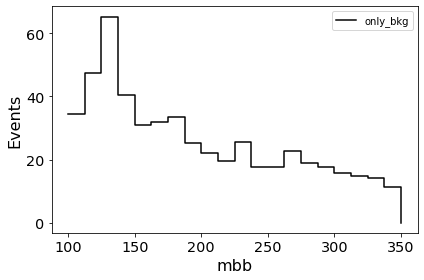

In [118]:
bins = 20
sig_bins=4


f,a = plt.subplots(1,1, figsize=(6, 4))

histo_range = (range_mbb[0], range_mbb[1])


a.step(x=regions_edge, y=bkg_bins_d,
        where="post", color = 'black', label = 'only_bkg')


#     a.set_ylim(bottom = 10**-1, top = max(max(counts_bs), max(counts_bs_2))*2)
#     a.errorbar(bincenters_bs_2, counts_bs_2, yerr=np.sqrt(counts_bs_2), fmt='.r', label='bkg + sig signal region')
#     a.errorbar(bincenters_bs, counts_bs, yerr=np.sqrt(counts_bs), fmt='.b', label='bkg + sig sidebands')
#     a[1].set_yscale('log')
a.legend(fontsize = 10)
a.set_ylabel('Events', fontsize=16)
a.set_xlabel('mbb', fontsize=16)
a.tick_params(labelsize='x-large')
#     a.set_title('After selection'.format(eff*100), fontsize = 14)

plt.tight_layout()
plt.show()

In [187]:
th_sel = 7

bins = 1
factor = 1

regions_edge = np.array([100. , 112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. ,
        212.5, 225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5,
        325. , 337.5, 350. ])

sample_val = 'test'

if sample_val == 'val':
    reweight = split_val
    dataset = sample
# elif sample_val == 'train':
#     reweight = split_train
#     dataset = sample
elif sample_val == 'test':
    reweight = split_test
    dataset = sample

bump_loss_bkg_u_list = []
bump_loss_sig_nominal_u = []

Ns_u_dict ={}
Ns_all  = {}

N_exp = 20

temp_matrix = np.zeros((N_exp, len(regions_edge),len(signals_u_dict[sig_inj])))
temp_matrix_bkg = np.zeros((N_exp, len(regions_edge)))

maxi_t = 2000
for idx_sig, sig_name in enumerate(nominal_signal_names):
    
    for row in range(N_exp):
        print(row)

        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)

        for i, sel in enumerate(selected_idx):
            print(sel)

            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)

        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####    
        th = th_sel
        bump_loss_bkg=np.sum(all_components_bkg, axis=1)

        bump_loss_bkg_u_list.append(bump_loss_bkg)

        test_loss_df = pd.DataFrame(dataset, columns = [cols_sel[start_c:end_c] + ['weight']])
        test_loss_df['loss'] = bump_loss_bkg
        test_loss_df['mbb'] = test_df['mbb'].values
    #     histo_range = (0,maxi_t)
    #     bins_back = int(maxi_t*5000)
    #     counts_dval, edges_dval = np.histogram((np.array(bump_loss_bkg)).astype(float),
    #                                            range=histo_range, bins =bins_back,
    #                                            weights=dataset[:,-1]*reweight) 

        bump_loss_sig = []
        sig_loss_df_list = []
        #In top we fixed the Nominal signals, here we loop on the systematics
        #and nominal distribution
        for sig_id, sig in enumerate(signals_u_dict[sig_inj]):          
            #the signal have the weights in last columns >>> predict on [:,:-1] slice
            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))

            sig_loss_df = pd.DataFrame(sig, columns = [cols_sel[start_c:end_c] + ['weight']])
            sig_loss_df['loss'] = np.sum(all_components_sig_temp, axis = 1)
            sig_loss_df['mbb'] = sig_df_mbb_u[sig_id]['mbb'].values

            bump_loss_sig.append(np.sum(all_components_sig_temp, axis = 1))     
            sig_loss_df_list.append(sig_loss_df)
            
        bump_loss_sig_nominal_u.append(np.sum(all_components_sig_temp, axis = 1)) 

        histo_range_test = (th, maxi_t)
        for i in range(len(signals_u_dict[sig_inj])):

            #For each signal we iterate on all the weight factor:
            #here only the nominal case
            sig_df_cut = sig_loss_df_list[i]
            sig_df_cut = sig_df_cut[np.array(sig_df_cut['loss']>th)]
            for col, region_end in enumerate(regions_edge[1:]):
                region_start = regions_edge[col]
    #             sig_df_region = sig_df_cut[((sig_df_cut['mbb']>=region_start)&(sig_df_cut['mbb']<region_end))] 

                counts_s, edges_s = np.histogram((sig_df_cut['mbb']).astype(float),
                                                 range=(region_start,region_end), 
                                            bins = 1, weights = sig_df_cut['weight'])

                temp_matrix[row,col,i]=(counts_s)    

    #             print(col, counts_s)

            test_df_cut = test_loss_df
            test_df_cut = test_df_cut[np.array(test_df_cut['loss']>th)]
            for col, region_end in enumerate(regions_edge[1:]):
                region_start = regions_edge[col]
    #             test_df_region = test_df_cut[((test_df_cut['mbb']>=region_start)&(test_df_cut['mbb']<region_end))] 

                counts_d, edges_d = np.histogram((test_df_cut['mbb']).astype(float),
                                                 range=(region_start,region_end), 
                                            bins = 1, weights = test_df_cut['weight']*reweight)

                temp_matrix_bkg[row,col]=(counts_d)  

                print(col, counts_d)

    # At the end of the N_exp for each signals we compact our 2-d image
    # starting to fix the signals, so the plane in the temp_matrix cube to extract

    for k in range(len(signals_u_dict[sig_inj])):
        temp_mean = []
        temp_std = []
        Ns_all = {}
        #Now loop on the factor and take the vector of the means and stds fo each on of that
        for l in range(len(regions_edge)):
            temp_mean.append(np.mean(temp_matrix[:,l,k]))
#             temp_std.append(np.std(temp_matrix[:,l,k]))
        Ns_all[signal_names_u[idx_sig][k]] = temp_mean

        #Put the vector so obtained in the dictory
        #1-key = nominal sig and 2-key the relative signal computed (k)
        #sig_name is the nominal name, signal_names_d is the [systs+nominal] names
        try:
            Ns_u_dict[sig_name][signal_names_u[idx_sig][k]]= Ns_all[signal_names_u[idx_sig][k]] 
        except: 
            Ns_u_dict[sig_name] = Ns_all
            print(Ns_all)
            
    temp_mean = []
    for l in range(len(regions_edge)):
        temp_mean.append(np.mean(temp_matrix_bkg[:,l]))
            
    bkg_bins_u = temp_mean

0
2
3
4
0 [33.6937171]
1 [47.96053452]
2 [64.8009955]
3 [42.07111377]
4 [31.3640675]
5 [31.64594463]
6 [33.37280108]
7 [25.50020644]
8 [22.07944755]
9 [18.91132509]
10 [26.80304601]
11 [18.86915633]
12 [17.08622457]
13 [22.10924872]
14 [19.64097166]
15 [18.06081787]
16 [16.55809218]
17 [15.09450039]
18 [13.89252026]
19 [11.37637726]
0 [33.6937171]
1 [47.96053452]
2 [64.8009955]
3 [42.07111377]
4 [31.3640675]
5 [31.64594463]
6 [33.37280108]
7 [25.50020644]
8 [22.07944755]
9 [18.91132509]
10 [26.80304601]
11 [18.86915633]
12 [17.08622457]
13 [22.10924872]
14 [19.64097166]
15 [18.06081787]
16 [16.55809218]
17 [15.09450039]
18 [13.89252026]
19 [11.37637726]
0 [33.6937171]
1 [47.96053452]
2 [64.8009955]
3 [42.07111377]
4 [31.3640675]
5 [31.64594463]
6 [33.37280108]
7 [25.50020644]
8 [22.07944755]
9 [18.91132509]
10 [26.80304601]
11 [18.86915633]
12 [17.08622457]
13 [22.10924872]
14 [19.64097166]
15 [18.06081787]
16 [16.55809218]
17 [15.09450039]
18 [13.89252026]
19 [11.37637726]
0 [33.69371

In [197]:
test_loss = np.array((np.mean(bump_loss_bkg_d_list, axis = 0), 
                    np.mean(bump_loss_bkg_u_list, axis = 0)))
nom_sig_loss = np.array((np.mean(bump_loss_sig_nominal_d, axis = 0), 
                    np.mean(bump_loss_sig_nominal_d, axis = 0)))

In [214]:
test_loss_df['loss'] = np.mean(test_loss, axis = 0)
test_loss_th_df = test_loss_df[np.array(test_loss_df['loss']) > th]

sig_df_mbb_nominal.loc[:, ['loss']] = np.mean(nom_sig_loss, axis = 0)
sig_df_mbb_nominal_th = sig_df_mbb_nominal[np.array(sig_df_mbb_nominal['loss']) > th]

In [213]:
bkg_bins = [(x+y)/2 for x,y in zip(bkg_bins_d, bkg_bins_u)]

In [268]:
np.array(test_loss_th_df.loc[:,['mbb']]).reshape(13893).shape

(13893,)

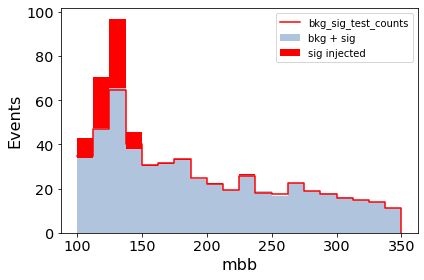

In [277]:
bins = 20
sig_bins=4


f,a = plt.subplots(1,1, figsize=(6, 4))

histo_range = (range_mbb[0], range_mbb[1])



a.step(x=regions_edge, y=bkg_bins,
        where="post", color = 'red', label = 'bkg_sig_test_counts')

a.hist([np.array(test_loss_th_df.loc[:,['mbb']]).reshape(len(test_loss_th_df)), 
         np.array(sig_df_mbb_nominal_th.loc[:,['mbb']]).reshape(len(sig_df_mbb_nominal_th))], 
       range = histo_range, stacked = True,
                        bins = bins, 
       weights=[np.array(test_loss_th_df.loc[:,['weight']]*reweight).reshape(len(test_loss_th_df)),
                np.array(sig_df_mbb_nominal_th.loc[:,['weight']]).reshape(len(sig_df_mbb_nominal_th))],
                color = ['lightsteelblue', 'red'], label=['bkg + sig', 'sig injected'])


#     a.set_ylim(bottom = 10**-1, top = max(max(counts_bs), max(counts_bs_2))*2)
#     a.errorbar(bincenters_bs_2, counts_bs_2, yerr=np.sqrt(counts_bs_2), fmt='.r', label='bkg + sig signal region')
#     a.errorbar(bincenters_bs, counts_bs, yerr=np.sqrt(counts_bs), fmt='.b', label='bkg + sig sidebands')
#     a[1].set_yscale('log')
a.legend(fontsize = 10)
a.set_ylabel('Events', fontsize=16)
a.set_xlabel('mbb', fontsize=16)
a.tick_params(labelsize='x-large')
#     a.set_title('After selection'.format(eff*100), fontsize = 14)

plt.tight_layout()
plt.show()

In [278]:
delta_d = []
for i, name in enumerate(nominal_signal_names):
    N0_list = []
    
    for bin_n in range(len(regions_edge)):
        N0d = Ns_d_dict[name][name][bin_n]
        N0u = Ns_u_dict[name][name][bin_n]   
        N0_list.append((N0d+N0u)/2)
    

    temp_matrix_syst = np.zeros((len(Ns_d_dict[name].keys()), len(regions_edge)))
    for ikv, (k, v) in enumerate(Ns_d_dict[name].items()):
        delta_yield_squared_history = []
 
        for iv, vv in enumerate(v):    

            delta_yield_squared = (np.abs(N0_list[iv]-vv))**2 
            delta_yield_squared_history.append(delta_yield_squared) 
            
            temp_matrix_syst[ikv, iv] = delta_yield_squared
            
    syst_d = []
    for j in range(len(regions_edge)):
        syst_d.append(np.sqrt(np.sum(temp_matrix_syst[:,j])))
     
    delta_d.append([N0_list, syst_d])

In [279]:
delta_u = []
for i, name in enumerate(nominal_signal_names):
    N0_list = []
    
    for bin_n in range(len(regions_edge)):
        N0d = Ns_d_dict[name][name][bin_n]
        N0u = Ns_u_dict[name][name][bin_n]   
        N0_list.append((N0d+N0u)/2)
    

    temp_matrix_syst = np.zeros((len(Ns_u_dict[name].keys()), len(regions_edge)))
    for ikv, (k, v) in enumerate(Ns_u_dict[name].items()):
        delta_yield_squared_history = []
 
        for iv, vv in enumerate(v):    

            delta_yield_squared = (np.abs(N0_list[iv]-vv))**2 
            delta_yield_squared_history.append(delta_yield_squared) 
            
            temp_matrix_syst[ikv, iv] = delta_yield_squared
            
    syst_u = []
    for j in range(len(regions_edge)):
        syst_u.append(np.sqrt(np.sum(temp_matrix_syst[:,j])))
     
    delta_u.append([N0_list, syst_u])

In [280]:
bkg_sig = np.array([x+y for x,y in zip(bkg_bins, N0_list)])

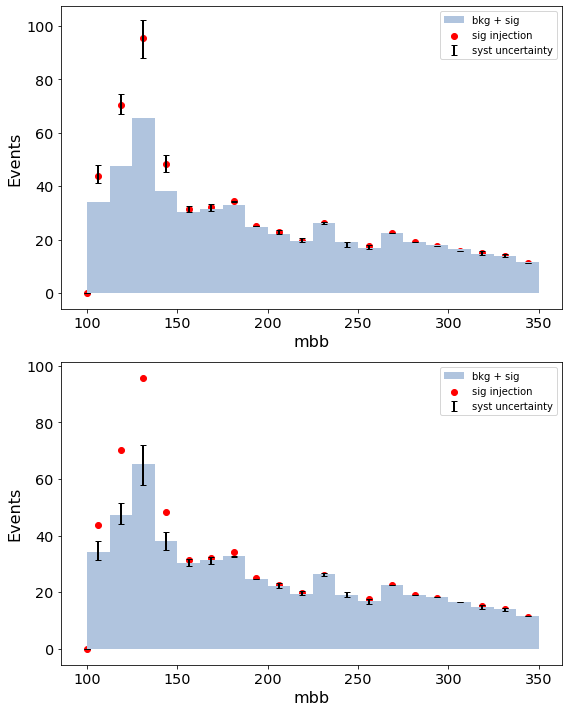

In [282]:
bins = 20
sig_bins=4

f,a = plt.subplots(2,1, figsize=(8, 10))

histo_range = (range_mbb[0], range_mbb[1])

bincenters = 0.5*(regions_edge[1:]+regions_edge[:-1])

# a.step(x=regions_edge, y=bkg_bins,
#         where="post", color = 'black', label = 'only_bkg')

a[0].hist((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
                        bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight,
                color = 'lightsteelblue', label='bkg + sig')

a[0].scatter(x=np.append(bincenters,range_mbb[0]), y=bkg_sig,
         color = 'red', label = 'sig injection')

a[0].errorbar(np.append(bincenters,range_mbb[0]), bkg_sig, 
                    ls="None",
                        yerr=np.array([[x for x in delta_d[0][1]]
                                       ,[x for x in delta_u[0][1]]]),                    
                                               elinewidth=2,capsize=3,
                    color = 'black', label = 'syst uncertainty') 


#     a.set_ylim(bottom = 10**-1, top = max(max(counts_bs), max(counts_bs_2))*2)
#     a.errorbar(bincenters_bs_2, counts_bs_2, yerr=np.sqrt(counts_bs_2), fmt='.r', label='bkg + sig signal region')
#     a.errorbar(bincenters_bs, counts_bs, yerr=np.sqrt(counts_bs), fmt='.b', label='bkg + sig sidebands')
#     a[1].set_yscale('log')
a[0].legend(fontsize = 10)
a[0].set_ylabel('Events', fontsize=16)
a[0].set_xlabel('mbb', fontsize=16)
a[0].tick_params(labelsize='x-large')
#     a.set_title('After selection'.format(eff*100), fontsize = 14)

counts_bs, edges_bs = np.histogram((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
                        bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight)

a[1].hist((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
                        bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight,
                color = 'lightsteelblue', label='bkg + sig')

a[1].scatter(x=np.append(bincenters,range_mbb[0]), y=bkg_sig,
         color = 'red', label = 'sig injection')

a[1].errorbar(np.append(bincenters,range_mbb[0]), np.append(counts_bs,0), 
                    ls="None",
                        yerr=np.array([[x for x in delta_d[0][1]]
                                       ,[x for x in delta_u[0][1]]]),                    
                                               elinewidth=2,capsize=3,
                    color = 'black', label = 'syst uncertainty') 


a[1].legend(fontsize = 10)
a[1].set_ylabel('Events', fontsize=16)
a[1].set_xlabel('mbb', fontsize=16)
a[1].tick_params(labelsize='x-large')

plt.savefig('plot_results/hist_syst_{}.pdf'.format(sig_inj))


plt.tight_layout()
plt.show()

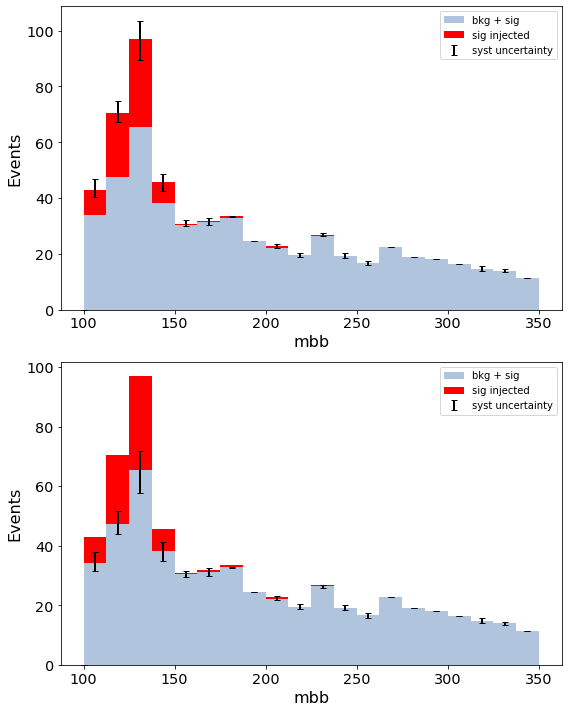

In [291]:
bins = 20
sig_bins=4

f,a = plt.subplots(2,1, figsize=(8, 10))

histo_range = (range_mbb[0], range_mbb[1])

bincenters = 0.5*(regions_edge[1:]+regions_edge[:-1])

# a.step(x=regions_edge, y=bkg_bins,
#         where="post", color = 'black', label = 'only_bkg')
counts_s, edges_s = np.histogram((np.array(sig_df_mbb_nominal_th.loc[:,['mbb']])).astype(float), 
                        range = histo_range,
                bins = bins, weights=np.array(sig_df_mbb_nominal_th.loc[:,['weight']]))

counts_bs, edges_bs = np.histogram((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
                        bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight)

counts_tot = [x+y for x,y in zip(counts_s, counts_bs)]

a[0].hist([np.array(test_loss_th_df.loc[:,['mbb']]).reshape(len(test_loss_th_df)), 
         np.array(sig_df_mbb_nominal_th.loc[:,['mbb']]).reshape(len(sig_df_mbb_nominal_th))], 
       range = histo_range, stacked = True,
                        bins = bins, 
       weights=[np.array(test_loss_th_df.loc[:,['weight']]*reweight).reshape(len(test_loss_th_df)),
                np.array(sig_df_mbb_nominal_th.loc[:,['weight']]).reshape(len(sig_df_mbb_nominal_th))],
                color = ['lightsteelblue', 'red'], label=['bkg + sig', 'sig injected'])

# a[0].scatter(x=np.append(bincenters,range_mbb[0]), y=bkg_sig,
#          color = 'red', label = 'sig injection')

a[0].errorbar(np.append(bincenters,range_mbb[0]), np.append(counts_tot,0), 
                    ls="None",
                        yerr=np.array([[x for x in delta_d[0][1]]
                                       ,[x for x in delta_u[0][1]]]),                    
                                               elinewidth=2,capsize=3,
                    color = 'black', label = 'syst uncertainty') 


#     a.set_ylim(bottom = 10**-1, top = max(max(counts_bs), max(counts_bs_2))*2)
#     a.errorbar(bincenters_bs_2, counts_bs_2, yerr=np.sqrt(counts_bs_2), fmt='.r', label='bkg + sig signal region')
#     a.errorbar(bincenters_bs, counts_bs, yerr=np.sqrt(counts_bs), fmt='.b', label='bkg + sig sidebands')
#     a[1].set_yscale('log')
a[0].legend(fontsize = 10)
a[0].set_ylabel('Events', fontsize=16)
a[0].set_xlabel('mbb', fontsize=16)
a[0].tick_params(labelsize='x-large')
#     a.set_title('After selection'.format(eff*100), fontsize = 14)

counts_bs, edges_bs = np.histogram((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
                        bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight)

# a[1].hist((np.array(test_loss_th_df.loc[:,'mbb'])).astype(float), range = histo_range,
#                         bins = bins, weights=np.array(test_loss_th_df.loc[:,'weight'])*reweight,
#                 color = 'lightsteelblue', label='bkg + sig')

a[1].hist([np.array(test_loss_th_df.loc[:,['mbb']]).reshape(len(test_loss_th_df)), 
         np.array(sig_df_mbb_nominal_th.loc[:,['mbb']]).reshape(len(sig_df_mbb_nominal_th))], 
       range = histo_range, stacked = True,
                        bins = bins, 
       weights=[np.array(test_loss_th_df.loc[:,['weight']]*reweight).reshape(len(test_loss_th_df)),
                np.array(sig_df_mbb_nominal_th.loc[:,['weight']]).reshape(len(sig_df_mbb_nominal_th))],
                color = ['lightsteelblue', 'red'], label=['bkg + sig', 'sig injected'])

# a[1].scatter(x=np.append(bincenters,range_mbb[0]), y=bkg_sig,
#          color = 'red', label = 'sig injection')

a[1].errorbar(np.append(bincenters,range_mbb[0]), np.append(counts_bs,0), 
                    ls="None",
                        yerr=np.array([[x for x in delta_d[0][1]]
                                       ,[x for x in delta_u[0][1]]]),                    
                                               elinewidth=2,capsize=3,
                    color = 'black', label = 'syst uncertainty') 


a[1].legend(fontsize = 10)
a[1].set_ylabel('Events', fontsize=16)
a[1].set_xlabel('mbb', fontsize=16)
a[1].tick_params(labelsize='x-large')

plt.savefig('plot_results/stacked_hist_syst_{}.pdf'.format(sig_inj))


plt.tight_layout()
plt.show()

In [159]:
bkg_sig

array([43.60452227, 69.63867581, 95.67432686, 48.52271873, 31.52971645,
       31.87518682, 34.09927572, 25.47873211, 22.64856385, 19.77175007,
       26.1814252 , 17.7519211 , 17.54626252, 22.5458528 , 18.94886041,
       17.74559154, 15.72320031, 14.88991201, 13.87757948, 10.96470062,
        0.        ])